In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
import ast

from nanonets import Simulation
from nanonets.utils import fft, total_harmonic_distortion, cross_correlation, BLUE_COLOR, RED_COLOR
from nanonets.utils import display_network, update_circle_colors, get_net_currents, create_weighted_undirected_graph, display_net_flow_graph, extract_harmonic_features
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from scipy import signal

plt.style.use(["science","bright","grid"])
# PATH        = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/res_disorder/"
# PATH_U      = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/amp_freq/"
# NET_PATHS   = "/home/j/j_mens07/phd/nanonets/scripts/2_funding_period/WP2/data/"

PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/res_disorder/"
PATH_U = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
NET_PATHS = "/home/jonasmensing/bagheera/nanonets/scripts/2_funding_period/WP2/data/"

### Load Output Data

In [3]:
N_PERIODS, SAMPLE_P_PERIOD  = 100, 40
N_NP, N_ELECTRODES          = 9, 8
N_SKIP, N_NETS              = 80, 32
AMPLITUDE                   = 0.02
FREQ_LIST_MHZ               = [0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.]
R_VALS                      = [50,100,200,400,800,1600]

topo = {"Nx": N_NP,"Ny": N_NP, "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
               [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],
               [N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]],
            "electrode_type": ['constant']*8}
sim_class   = Simulation(topo)
G_obj       = sim_class.get_graph()
pos         = sim_class.get_positions()
pos         = {(key+8 if key >= 0 else (abs(key)-1)) : (val) for key, val in pos.items()}
E_CHARGE    = sim_class.ELE_CHARGE_A_C
CAP_MAT     = sim_class.get_capacitance_matrix()

In [4]:
dts         = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps     = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time        = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data_u      = {freq : pd.read_csv(f"{PATH_U}Nx=9_Ny=9_Ne=8_{freq:.3f}_{0.02:.3f}_constant.csv") for freq in FREQ_LIST_MHZ}
data        = {}
states      = {}
currents    = {}
for R in R_VALS:
    data[R]     = {n : {freq : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{freq:.3f}_mean2_{R:.1f}_{n}.csv") for freq in FREQ_LIST_MHZ} for n in range(N_NETS)}
    # states[R]   = {n : {freq : pd.read_csv(f"{PATH}mean_state_Nx=9_Ny=9_Ne=8_{freq:.3f}_mean2_{R:.1f}_{n}.csv") for freq in FREQ_LIST_MHZ} for n in range(N_NETS)}
    # currents[R] = {n : {freq : pd.read_csv(f"{PATH}net_currents_Nx=9_Ny=9_Ne=8_{freq:.3f}_mean2_{R:.1f}_{n}.csv").iloc[N_SKIP*SAMPLE_P_PERIOD:,:]*1e-6 for freq in FREQ_LIST_MHZ} for n in range(N_NETS)}

In [8]:
# p   = {R : {n : {freq : states[R][n][freq].iloc[:,8:].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for n in range(N_NETS)} for R in R_VALS}
x       = {R : {n : {freq : data[R][n][freq]['E0'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for n in range(N_NETS)} for R in R_VALS}
y       = {R : {n : {freq : data[R][n][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for n in range(N_NETS)} for R in R_VALS}
y_e     = {R : {n : {freq : data[R][n][freq]['Error'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for n in range(N_NETS)} for R in R_VALS}
y_u     = {freq : data_u[freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ}
y_u_e   = {freq : data_u[freq]['Error'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ}

### Gain Plots

In [58]:
2048*2

4096

In [ ]:
B = 200

# Disorder
gain_data = {}
for R in R_VALS:
    gain_data[R] = {}
    for N in range(N_NETS):
        gain_data[R][N] = []
        for _ in range(B):
            h0s     = np.array([extract_harmonic_features(y[R][N][f0]+np.random.normal(0,y_e[R][N][f0]/1.96), [1], mode='abs', pad_len=4096) for f0 in FREQ_LIST_MHZ])
            ratio   = h0s/h0s[0]
            gain_dB = 20*np.log10(ratio)
            
            gain_data[R][N].append(gain_dB)

# Max Gain
deltaG = {}
for R in R_VALS:
    deltaG[R] = []
    for N in range(N_NETS):
        for b in range(B):
            deltaG[R].append((np.max(gain_data[R][N][b]) - gain_data[R][N][b][0])[0])

f_at_max_gain = {}
for R in R_VALS:
    f_at_max_gain[R] = []
    for N in range(N_NETS):
        for b in range(B):
            f_at_max_gain[R].append(FREQ_LIST_MHZ[np.argmax(gain_data[R][N][b])])

# deltaG                      = pd.DataFrame([[(np.max(gain_data[R][n]) - gain_data[R][n][0])[0] for R in R_VALS] for n in range(N_NETS)], columns=[f"$R_2 = {R}$ MHz" for R in R_VALS])
# deltaG["$R_2 = 25$ MHz"]    = (np.max(gain_u) - gain_u[0])[0]
# deltaG                      = deltaG.loc[:,["$R_2 = 25$ MHz"]+[f"$R_2 = {R}$ MHz" for R in R_VALS]].replace(0,np.nan)

# # Freq Position
# f_at_max_gain       = pd.DataFrame([[FREQ_LIST_MHZ[np.argmax(gain_data[R][n])] for R in R_VALS] for n in range(N_NETS)], columns=R_VALS)
# f_at_max_gain[25]   = 10.0
# f_at_max_gain       = f_at_max_gain.loc[:,[25]+R_VALS]

In [89]:
# Reference
deltaG_u = []
for N in range(N_NETS):
    for b in range(B):
        h0s     = np.array([extract_harmonic_features(y_u[f0]+np.random.normal(0,y_u_e[f0]/1.96), [1], mode='abs', pad_len=4096) for f0 in FREQ_LIST_MHZ])
        gain_u  = h0s/h0s[0]
        deltaG_u.append((np.max(gain_u) - gain_u[0])[0])

f_at_max_gain_u = []
for i in range(N_NETS*B):
    f_at_max_gain_u.append(FREQ_LIST_MHZ[np.argmax(deltaG_u[i])])

In [128]:
kappas          = [1,2,4,8,16,32,64]

delta_G_df      = pd.DataFrame(deltaG)
delta_G_df[25]  = deltaG_u
delta_G_df      = delta_G_df.loc[:,[25]+R_VALS]

f_at_max_gain_df        = pd.DataFrame(f_at_max_gain)
f_at_max_gain_df[25]    = f_at_max_gain_u
f_at_max_gain_df        = f_at_max_gain_df.loc[:,[25]+R_VALS]

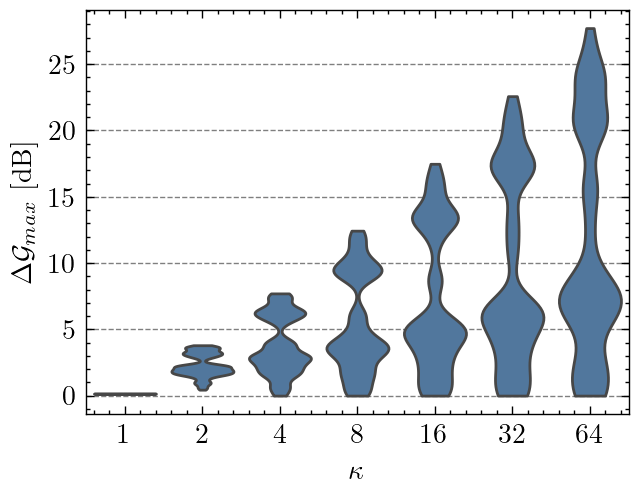

In [107]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.violinplot(delta_G_df.rename(columns={r : k for r, k in zip([25]+R_VALS, kappas)}), color=BLUE_COLOR, fill=True, cut=0, inner=None, scale='width')
_       = ax.set_xlabel("$\\kappa$")
_       = ax.set_ylabel("$\\Delta \\mathcal{G}_{max}$ [dB]")

fig.savefig(f"plots/pdf/delta_G_max_vs_kappa.pdf", transparent=False)
fig.savefig(f"plots/svg/delta_G_max_vs_kappa.svg", transparent=True)
fig.savefig(f"plots/png/delta_G_max_vs_kappa.png", transparent=False)

In [149]:
df1         = delta_G_df.rename(columns={r : k for r, k in zip([25]+R_VALS, kappas)}).melt(var_name='k', value_name='G_max')
df2         = f_at_max_gain_df.rename(columns={r : k for r, k in zip([25]+R_VALS, kappas)}).melt(var_name='k', value_name='f')
df1['f']    = df2['f']

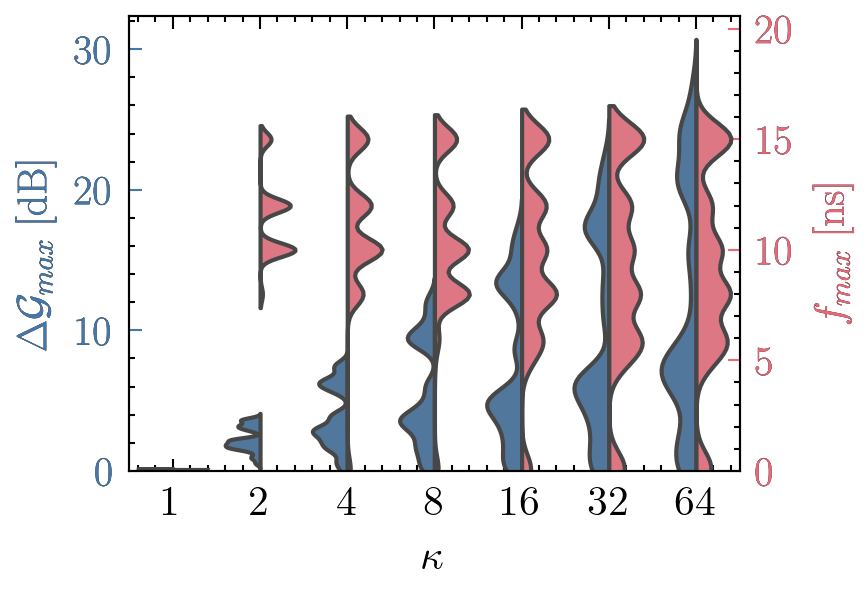

In [176]:
import matplotlib.patheffects as pe

fig, ax0  = plt.subplots(dpi=300)

w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

ax1     = ax0.twinx()
order   = ['G_max','f']
for ax, var_name in zip([ax0,ax1],order):
    sns.violinplot(df1.assign(var=var_name), x='k', y=var_name, hue='var', hue_order=order, ax=ax, split=True, inner=None, scale='width')
_   = ax0.set_xlabel("$\\kappa$")
l0   = ax0.set_ylabel("$\\Delta \\mathcal{G}_{max}~[\mathrm{dB}]$",color=BLUE_COLOR)
l1  = ax1.set_ylabel("$f_{max}~[\mathrm{ns}]$",color=RED_COLOR)
l0.set_path_effects([pe.Stroke(linewidth=0.1, foreground='black'),pe.Normal()])
l1.set_path_effects([pe.Stroke(linewidth=0.1, foreground='black'),pe.Normal()])

_   = ax0.set_ylim(0)
_   = ax1.set_ylim(0)
ax0.grid(False)
ax1.grid(False)
ax0.get_legend().remove()
ax1.get_legend().remove()
ax0.tick_params(axis='y', colors=BLUE_COLOR)
ax1.tick_params(axis='y', colors=RED_COLOR)

for lbl in ax0.get_yticklabels():
    lbl.set_path_effects([pe.Stroke(linewidth=0.1, foreground='black'),pe.Normal()])
for lbl in ax1.get_yticklabels():
    lbl.set_path_effects([pe.Stroke(linewidth=0.1, foreground='black'),pe.Normal()])


fig.savefig(f"plots/pdf/delta_G_max_and_f_max_vs_kappa.pdf", transparent=False)
fig.savefig(f"plots/svg/delta_G_max_and_f_max_vs_kappa.svg", transparent=True)
fig.savefig(f"plots/png/delta_G_max_and_f_max_vs_kappa.png", transparent=False)

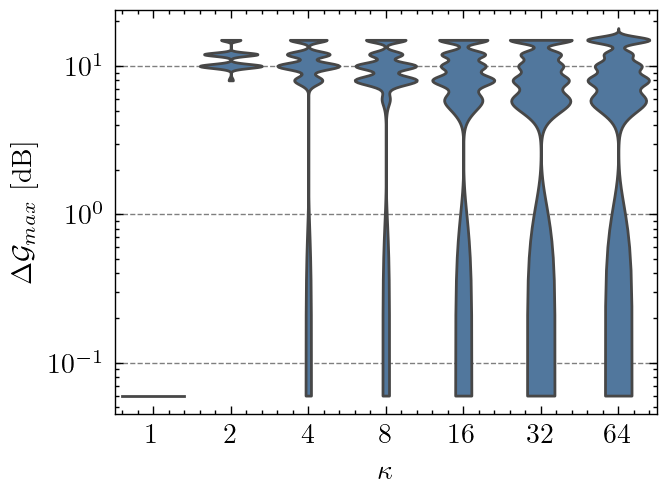

In [102]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.violinplot(f_at_max_gain_df.rename(columns={r : k for r, k in zip([25]+R_VALS, kappas)}), color=BLUE_COLOR, fill=True, cut=0, inner=None, scale='width')
_       = ax.set_xlabel("$\\kappa$")
_       = ax.set_ylabel("$\\Delta \\mathcal{G}_{max}$ [dB]")
_       = ax.set_yscale('log')

# fig.savefig(f"plots/pdf/delta_G_max_vs_kappa.pdf", transparent=False)
# fig.savefig(f"plots/svg/delta_G_max_vs_kappa.svg", transparent=True)
# fig.savefig(f"plots/png/delta_G_max_vs_kappa.png", transparent=False)

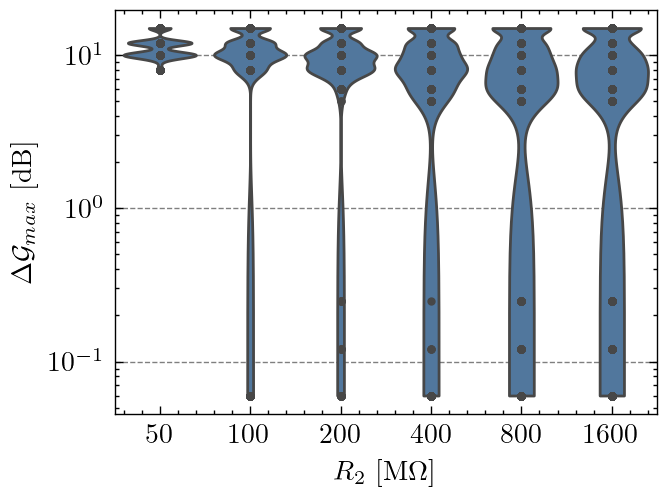

In [56]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.violinplot(pd.DataFrame(f_at_max_gain), color=BLUE_COLOR, fill=True, cut=0, inner='point', scale='width')
_       = ax.set_xlabel("$R_2$ [M$\Omega$]")
_       = ax.set_ylabel("$\\Delta \\mathcal{G}_{max}$ [dB]")
_       = ax.set_yscale('log')


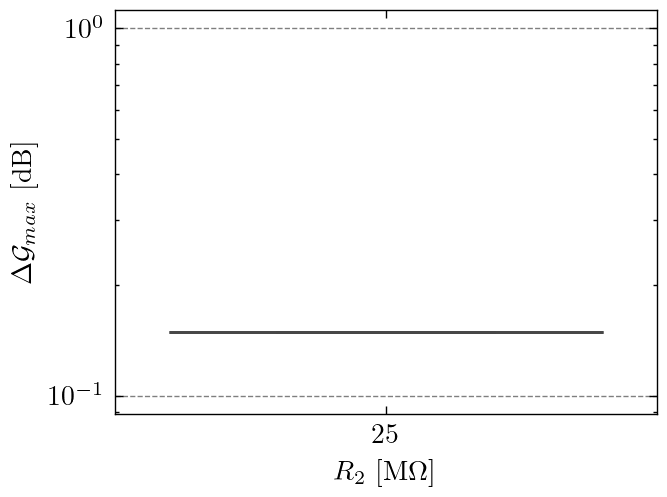

In [37]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.boxplot(deltaG.rename(columns={f"$R_2 = {R}$ MHz":R for R in [25]+R_VALS}), color=BLUE_COLOR)
# ax      = sns.violinplot(deltaG.rename(columns={f"$R_2 = {R}$ MHz":R for R in [25]+R_VALS}), color=BLUE_COLOR, fill=True, cut=0, inner='point', scale='width')
_       = ax.set_xlabel("$R_2$ [M$\Omega$]")
_       = ax.set_ylabel("$\\Delta \\mathcal{G}_{max}$ [dB]")
_       = ax.set_yscale('log')


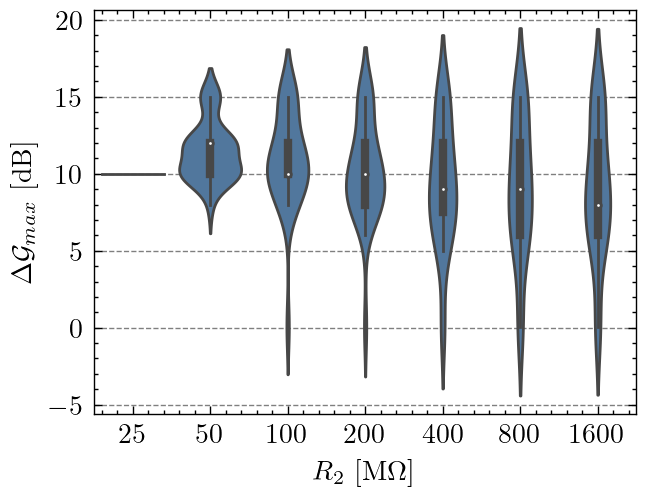

In [24]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.violinplot(f_at_max_gain, color=BLUE_COLOR)
# ax      = sns.violinplot(deltaG.rename(columns={f"$R_2 = {R}$ MHz":R for R in [25]+R_VALS}), color=BLUE_COLOR, fill=True, cut=0, inner='point', scale='width')
_       = ax.set_xlabel("$R_2$ [M$\Omega$]")
_       = ax.set_ylabel("$\\Delta \\mathcal{G}_{max}$ [dB]")
# _       = ax.set_yscale('log')

In [11]:
f_at_max_gain

,50,100,200,400,800,1600
0,15.0,15.00,15.00,15.00,15.00,15.00
1,8.0,0.06,0.06,0.06,0.25,0.25
2,10.0,10.00,10.00,10.00,8.00,8.00
3,10.0,10.00,10.00,8.00,10.00,8.00
4,12.0,15.00,15.00,15.00,15.00,15.00
5,12.0,12.00,12.00,12.00,12.00,12.00
6,12.0,12.00,12.00,12.00,12.00,10.00
7,12.0,12.00,10.00,10.00,10.00,10.00
8,10.0,8.00,8.00,6.00,6.00,6.00
9,12.0,12.00,12.00,12.00,12.00,12.00


/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.

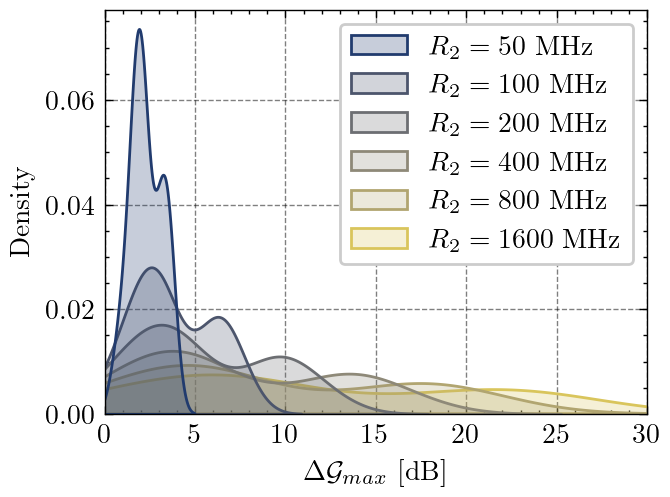

In [112]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(deltaG.iloc[:,1:], color=BLUE_COLOR, fill=True, palette='cividis', log_scale=False)
_       = ax.set_xlim(0.0,30)
_       = ax.set_xlabel("$\\Delta \\mathcal{G}_{max}$ [dB]")

fig.savefig(f"plots/pdf/delta_G_max_vs_R_dist.pdf", transparent=False)
fig.savefig(f"plots/svg/delta_G_max_vs_R_dist.svg", transparent=True)
fig.savefig(f"plots/png/delta_G_max_vs_R_dist.png", transparent=False)

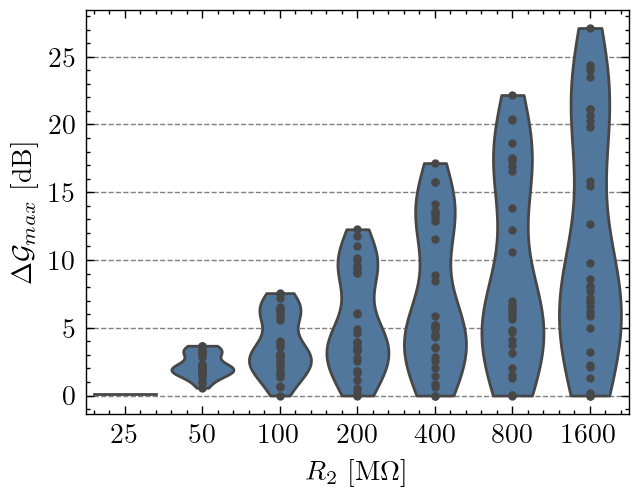

In [10]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.violinplot(deltaG.rename(columns={f"$R_2 = {R}$ MHz":R for R in [25]+R_VALS}), color=BLUE_COLOR, fill=True, cut=0, inner='point', scale='width')
_       = ax.set_xlabel("$R_2$ [M$\Omega$]")
_       = ax.set_ylabel("$\\Delta \\mathcal{G}_{max}$ [dB]")

# fig.savefig(f"plots/pdf/delta_G_max_vs_R.pdf", transparent=False)
# fig.savefig(f"plots/svg/delta_G_max_vs_R.svg", transparent=True)
# fig.savefig(f"plots/png/delta_G_max_vs_R.png", transparent=False)

/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


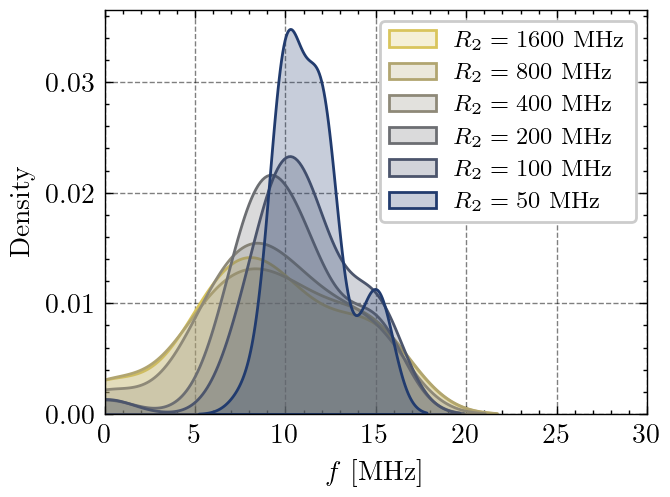

In [226]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(f_at_max_gain, color=BLUE_COLOR, fill=True, palette='cividis', legend=False)
_       = ax.set_xlim(0.0,30)
_       = ax.set_xlabel("$f$ [MHz]")

# Update legend
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(new_labels[::-1], loc="upper right", fontsize='small', ncol=1)

fig.savefig(f"plots/pdf/f_at_max_gain.pdf", transparent=False)
fig.savefig(f"plots/svg/f_at_max_gain.svg", transparent=True)
fig.savefig(f"plots/png/f_at_max_gain.png", transparent=False)

### Min Mid Max Gain

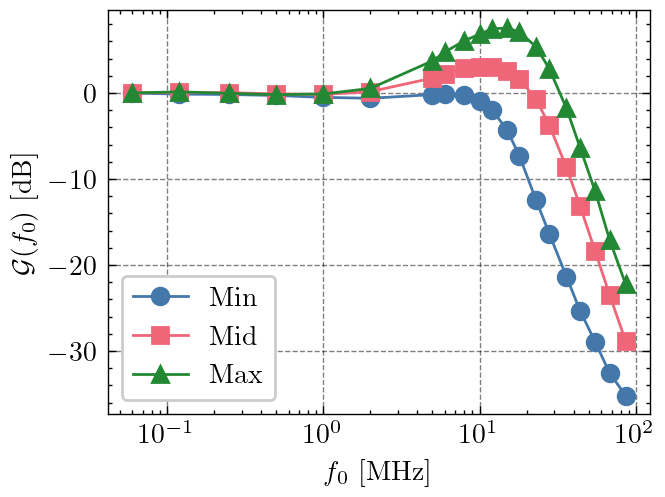

In [118]:
R       = 100
idx_g   = [np.argsort(deltaG[f"$R_2 = {R}$ MHz"].values)[0],
           np.argsort(deltaG[f"$R_2 = {R}$ MHz"].values)[16],
           np.argsort(deltaG[f"$R_2 = {R}$ MHz"].values)[-1]]

ma  = ['o','s','^']
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for n, i in enumerate(idx_g):
    _   = ax.errorbar(FREQ_LIST_MHZ, gain_data[R][i], marker=ma[n])
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.set_ylabel("$\\mathcal{G}(f_0)$ [dB]")
_   = ax.set_xscale('log')
_   = ax.legend(['Min','Mid','Max'])

fig.savefig(f"plots/pdf/gain_vs_f0_at_R_{R}.pdf", transparent=False)
fig.savefig(f"plots/svg/gain_vs_f0_at_R_{R}.svg", transparent=True)
fig.savefig(f"plots/png/gain_vs_f0_at_R_{R}.png", transparent=False)

### Nonlinearity

In [119]:
def compute_spectral_centroid(amplitudes, harmonic_orders, exclude_fundamental=True):
    """
    Calculates the Spectral Centroid (Center of Mass of the Harmonic Spectrum).
    
    Formula: C = Sum(n * A_n^2) / Sum(A_n^2)
    (Weighted by Power, consistent with energy distribution)
    
    Parameters:
    - amplitudes: Array of magnitudes [A_1, A_3, A_5...]
    - harmonic_orders: Array of harmonic indices [1, 3, 5...]
    - exclude_fundamental: If True, calculates the centroid of the DISTORTION only (n > 1).
                           If False, includes the fundamental frequency.
    
    Returns:
    - centroid: The weighted average harmonic order (e.g., 3.5 means energy is between n=3 and n=5).
    """
    # Ensure inputs are numpy arrays
    amps = np.asarray(amplitudes)
    ords = np.asarray(harmonic_orders)
    
    # 1. Filter: Decide whether to include n=1
    if exclude_fundamental:
        # Only keep harmonics where n > 1
        mask = ords > 1
        valid_amps = amps[mask]
        valid_ords = ords[mask]
    else:
        valid_amps = amps
        valid_ords = ords
        
    # 2. Calculate Power (Square of Amplitude)
    power = valid_amps**2
    total_power = np.sum(power)
    
    # 3. Safety Check for Zero Distortion
    if total_power < 1e-20:
        return np.nan # No harmonic energy exists
        
    # 4. Calculate Centroid
    # Sum(n * Power) / Sum(Power)
    centroid = np.sum(valid_ords * power) / total_power
    
    return centroid

def compute_thd(amplitudes):
    """
    Calculates Total Harmonic Distortion (THD).
    Input: Array of amplitudes [A_fund, A_harm1, A_harm2, ...]
    """
    if len(amplitudes) < 2 or amplitudes[0] == 0:
        return 0.0
        
    power_fund = amplitudes[0]**2
    power_harm = np.sum(amplitudes[1:]**2)
    
    return np.sqrt(power_harm) / np.sqrt(power_fund)

In [227]:
N_periods   = 20
dim         = 9
n_vals      = np.arange(1,dim+1,1)
amplitudes  = {}
for R in R_VALS:
    amplitudes[R] = {}
    for n in range(N_NETS):
        amplitudes[R][n] = np.array([extract_harmonic_features(y[R][n][f0],n_vals,mode='abs') for f0 in FREQ_LIST_MHZ])
centr   = {R : {n : [compute_spectral_centroid(amplitudes[R][n][i], n_vals, True) for i in range(len(FREQ_LIST_MHZ))] for n in range(N_NETS)} for R in R_VALS}
thds    = {R : {n : [compute_thd(amplitudes[R][n][i]) for i in range(len(FREQ_LIST_MHZ))] for n in range(N_NETS)} for R in R_VALS}
thds_u  = [compute_thd(extract_harmonic_features(y_u[f0],n_vals,mode='abs')) for f0 in FREQ_LIST_MHZ]
centr_u = [compute_spectral_centroid(extract_harmonic_features(y_u[f0],n_vals,mode='abs'),n_vals) for f0 in FREQ_LIST_MHZ]

f_at_max_thd = pd.DataFrame([[FREQ_LIST_MHZ[np.argmax(thds[R][n])] for R in R_VALS] for n in range(N_NETS)], columns=R_VALS)

In [183]:
thd_df      = pd.DataFrame()
centr_df    = pd.DataFrame()
for R, val in thds.items():
    df          = pd.DataFrame(val)
    df['f0']    = FREQ_LIST_MHZ
    df          = df.melt(id_vars='f0',var_name='n',value_name='thd')
    df['R']     = R
    thd_df      = pd.concat([thd_df,df],ignore_index=True)

    df          = pd.DataFrame(centr[R])
    df['f0']    = FREQ_LIST_MHZ
    df          = df.melt(id_vars='f0',var_name='n',value_name='centr')
    df['R']     = R
    centr_df    = pd.concat([centr_df,df],ignore_index=True)

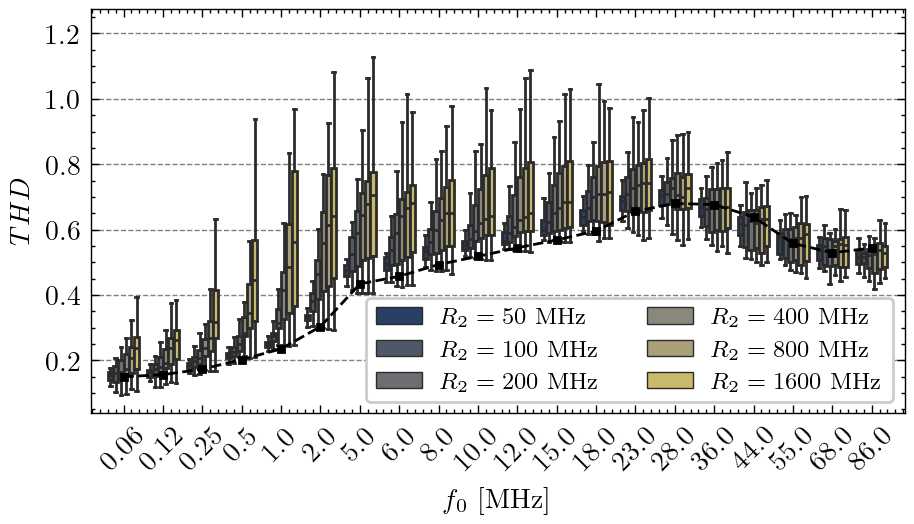

In [ ]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot()
ax  = sns.boxplot(thd_df, x='f0', y='thd', hue='R', ax=ax, color=BLUE_COLOR, palette='cividis', fliersize=0)
_   = ax.set_ylabel("$THD$")
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.plot(thds_u, color='black', ls='--', marker='s', zorder=10, ms=2)
_   = plt.xticks(rotation=45)

# Update legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(handles=handles, labels=new_labels, loc="lower right", fontsize='small', ncol=2)

fig.savefig(f"plots/pdf/thd_box_vs_f0_vs_R.pdf", transparent=False)
fig.savefig(f"plots/svg/thd_box_vs_f0_vs_R.svg", transparent=True)
fig.savefig(f"plots/png/thd_box_vs_f0_vs_R.png", transparent=False)

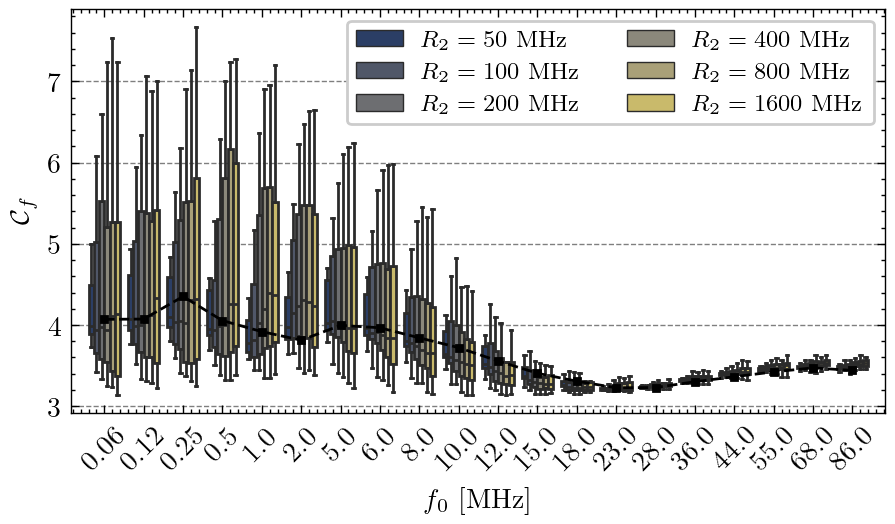

In [190]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot()
ax  = sns.boxplot(centr_df, x='f0', y='centr', hue='R', ax=ax, color=BLUE_COLOR, palette='cividis', fliersize=0)
_   = ax.set_ylabel("$\mathcal{C}_f$")
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.plot(centr_u, color='black', ls='--', marker='s', zorder=10, ms=2)
_   = plt.xticks(rotation=45)

# Update legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=2)

fig.savefig(f"plots/pdf/Cf_box_vs_f0_vs_R.pdf", transparent=False)
fig.savefig(f"plots/svg/Cf_box_vs_f0_vs_R.svg", transparent=True)
fig.savefig(f"plots/png/Cf_box_vs_f0_vs_R.png", transparent=False)

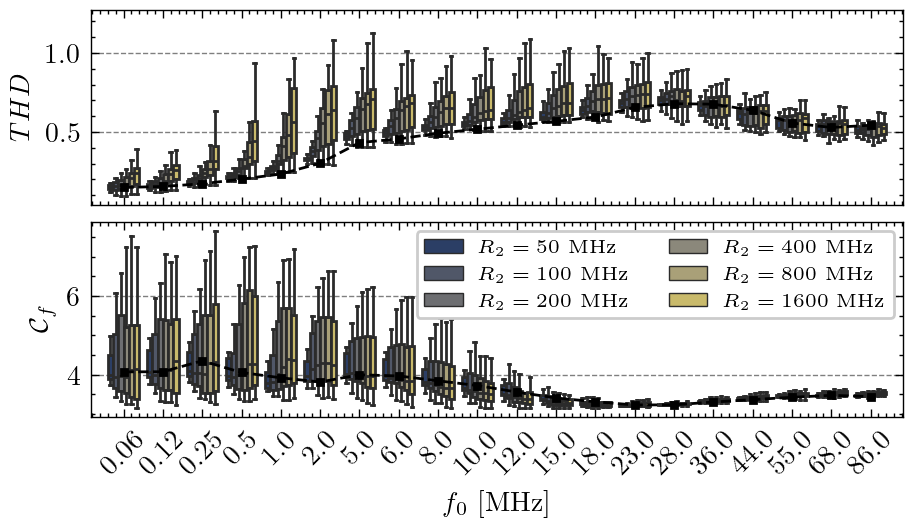

In [204]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.3)
ax  = fig.add_subplot(2,1,1)
ax  = sns.boxplot(thd_df, x='f0', y='thd', hue='R', ax=ax, color=BLUE_COLOR, palette='cividis', fliersize=0)
_   = ax.set_ylabel("$THD$")
_   = ax.set_xlabel("")
_   = ax.set_xticklabels("")
_   = ax.plot(thds_u, color='black', ls='--', marker='s', zorder=10, ms=2)
_   = plt.xticks(rotation=45)
ax.get_legend().remove()

ax  = fig.add_subplot(2,1,2)
ax  = sns.boxplot(centr_df, x='f0', y='centr', hue='R', ax=ax, color=BLUE_COLOR, palette='cividis', fliersize=0)
_   = ax.set_ylabel("$\mathcal{C}_f$")
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.plot(centr_u, color='black', ls='--', marker='s', zorder=10, ms=2)
_   = plt.xticks(rotation=45)

# Update legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='x-small', ncol=2)

fig.savefig(f"plots/pdf/thd_and_Cf_box_vs_f0_vs_R.pdf", transparent=False)
fig.savefig(f"plots/svg/thd_and_Cf_box_vs_f0_vs_R.svg", transparent=True)
fig.savefig(f"plots/png/thd_and_Cf_box_vs_f0_vs_R.png", transparent=False)

/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jonasmensing/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


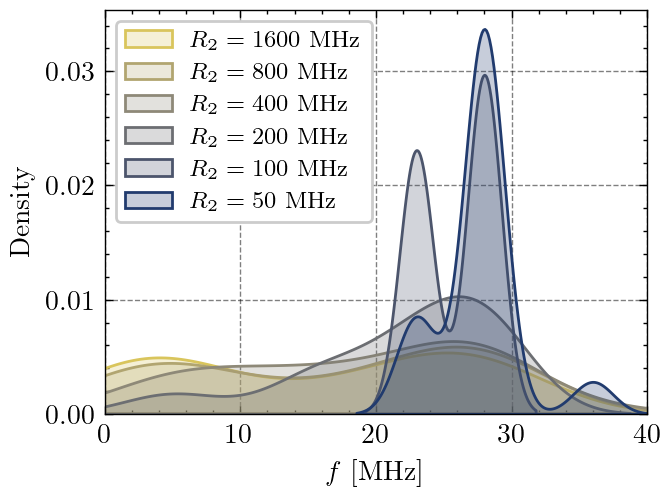

In [231]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(f_at_max_thd, color=BLUE_COLOR, fill=True, palette='cividis', legend=False)
_       = ax.set_xlim(0.0,40)
_       = ax.set_xlabel("$f$ [MHz]")

# Update legend
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(new_labels[::-1], loc="upper left", fontsize='small', ncol=1)

fig.savefig(f"plots/pdf/f_at_max_thd.pdf", transparent=False)
fig.savefig(f"plots/svg/f_at_max_thd.svg", transparent=True)
fig.savefig(f"plots/png/f_at_max_thd.png", transparent=False)

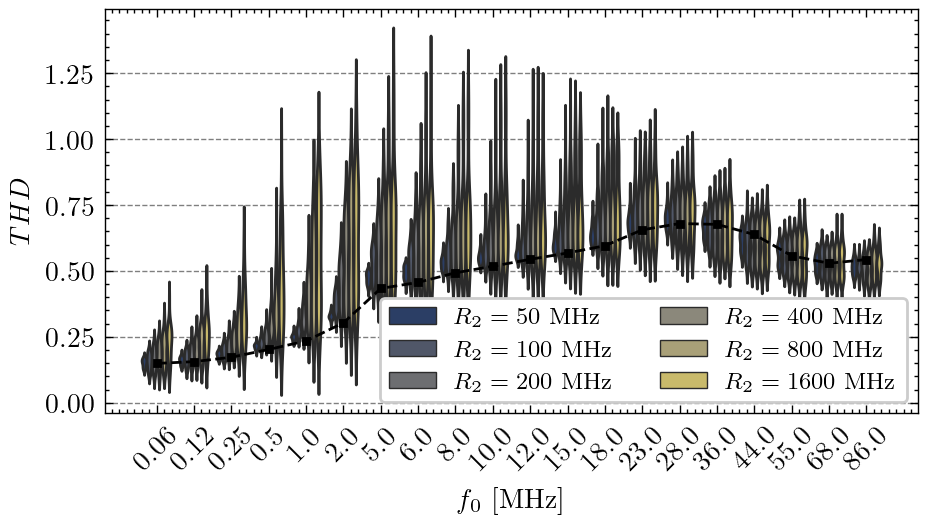

In [191]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot()
ax  = sns.violinplot(thd_df, x='f0', y='thd', hue='R', ax=ax, color=BLUE_COLOR, scale='width', inner=None, palette='cividis')
_   = ax.set_ylabel("$THD$")
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.plot(thds_u, color='black', ls='--', marker='s', zorder=10, ms=2)
_   = plt.xticks(rotation=45)

# Update legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(handles=handles, labels=new_labels, loc="lower right", fontsize='small', ncol=2)

fig.savefig(f"plots/pdf/thd_violin_vs_f0_vs_R.pdf", transparent=False)
fig.savefig(f"plots/svg/thd_violin_vs_f0_vs_R.svg", transparent=True)
fig.savefig(f"plots/png/thd_violin_vs_f0_vs_R.png", transparent=False)

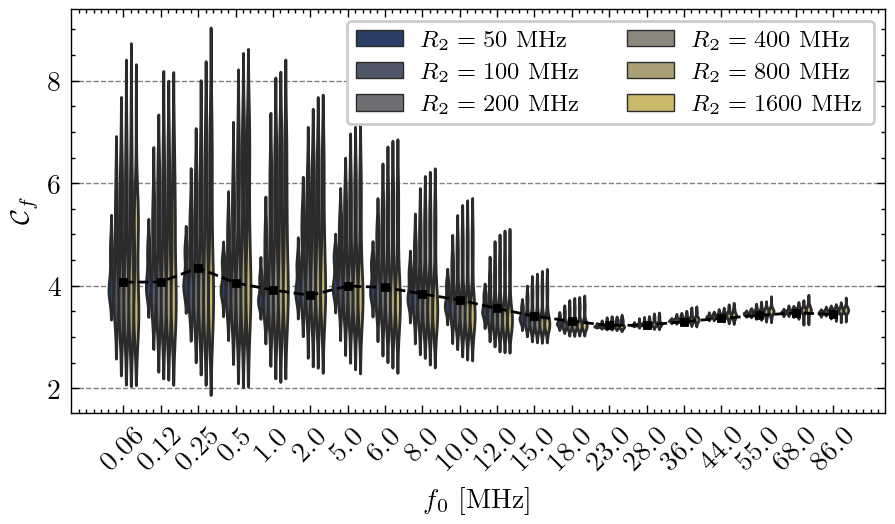

In [192]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)
ax  = fig.add_subplot()
ax  = sns.violinplot(centr_df, x='f0', y='centr', hue='R', ax=ax, color=BLUE_COLOR, scale='width', inner=None, palette='cividis')
_   = ax.set_ylabel("$\mathcal{C}_f$")
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.plot(centr_u, color='black', ls='--', marker='s', zorder=10, ms=2)
_   = plt.xticks(rotation=45)

# Update legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [f"$R_2 = {R}$ MHz" for R in R_VALS]
_ = ax.legend(handles=handles, labels=new_labels, loc="upper right", fontsize='small', ncol=2)

fig.savefig(f"plots/pdf/Cf_violin_vs_f0_vs_R.pdf", transparent=False)
fig.savefig(f"plots/svg/Cf_violin_vs_f0_vs_R.svg", transparent=True)
fig.savefig(f"plots/png/Cf_violin_vs_f0_vs_R.png", transparent=False)

---

### Load Network Currents at min/mid/max Gain and THD

In [ ]:
# R = 100
R      = 1600
idx_g  = [np.argsort(deltaG[R].values)[0],
          np.argsort(deltaG[R].values)[16],
          np.argsort(deltaG[R].values)[-1]]
idx_b  = [15,30,20]

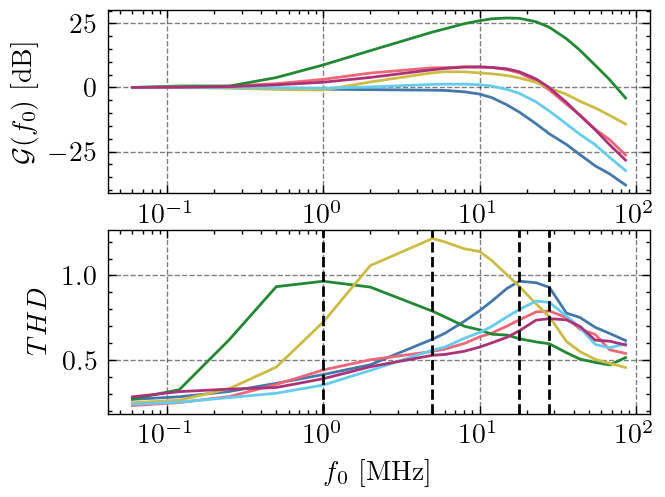

In [82]:
gain_at_idx = [gain_data[R].copy()[i]['gain'] for i in idx_g+idx_b]
thd_at_idx  = [thds[R].copy()[i] for i in idx_g+idx_b]
fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
for val1, val2 in zip(gain_at_idx,thd_at_idx):
       _   = ax1.plot(FREQ_LIST_MHZ, val1)
       _   = ax2.plot(FREQ_LIST_MHZ, val2)
for f_val in [1.0,18.0,28.0,5.0]:
       _   = plt.axvline(f_val, color='black', ls='--')
_   = ax2.set_xlabel("$f_0$ [MHz]")
_   = ax1.set_ylabel("$\\mathcal{G}(f_0)$ [dB]")
_   = ax2.set_ylabel("$THD$")
_   = ax1.set_xscale('log')
_   = ax2.set_xscale('log')

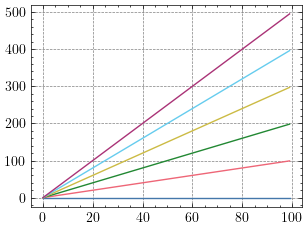

In [5]:
for i in range(6):
    plt.plot(i*np.arange(100))

- idx_vals for Min,Mid,Max Gain = [12,9,4]
- idx_vals for Min,Max Beta = [15,20] 
- f0_vals = [1.0,18.0,28.0]

In [ ]:
min_G_idx   = 30
max_G_idx   = 4
GAIN_IDX    = [min_G_idx, max_G_idx]
min_THD_idx = 19
max_THD_idx = 15
THD_IDX     = [min_THD_idx, max_THD_idx]
currents    = {}
for R in R_VALS:
    currents[R] = {n : {freq : pd.read_csv(f"{PATH}net_currents_Nx=9_Ny=9_Ne=8_{freq:.3f}_mean2_{R:.1f}_{n}.csv").iloc[N_SKIP*SAMPLE_P_PERIOD:,:]*1e-6
                        for freq in FREQ_LIST_MHZ} for n in [min_G_idx, max_G_idx, min_THD_idx, max_THD_idx]}

### Min Gain vs Max Gain

In [187]:
active_bonds_min_gain = {}
active_bonds_max_gain = {}
for R in R_VALS:
    l1_tmp = []
    l2_tmp = []
    for f0 in FREQ_LIST_MHZ:
        df_net  = get_net_currents(currents[R][min_G_idx][f0])
        # df_net  = currents[R][min_G_idx][f0]
        N_bond  = len(df_net.columns)
        rms     = np.sqrt((df_net**2).sum())
        P_min   = np.sum(rms)**2 / (N_bond * np.sum(rms**2))
        l1_tmp.append(P_min)

        df_net  = get_net_currents(currents[R][max_G_idx][f0])
        # df_net  = currents[R][max_G_idx][f0]
        N_bond  = len(df_net.columns)
        rms     = np.sqrt((df_net**2).sum())
        P_max   = np.sum(rms)**2 / (N_bond * np.sum(rms**2))
        l2_tmp.append(P_max)

    active_bonds_min_gain[R] = l1_tmp
    active_bonds_max_gain[R] = l2_tmp

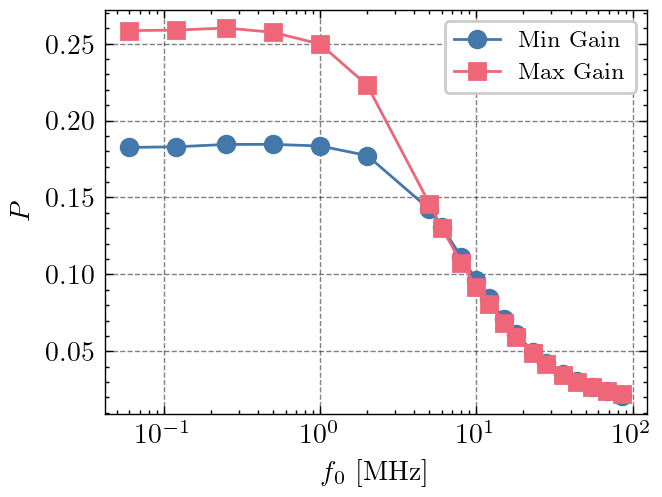

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
_   = ax.plot(FREQ_LIST_MHZ, active_bonds_min_gain[1600], 'o-', label='Min Gain')
_   = ax.plot(FREQ_LIST_MHZ, active_bonds_max_gain[1600], 's-', label='Max Gain')
_   = ax.set_xscale('log')
_   = ax.legend(fontsize='small')
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.set_ylabel("$P$")

fig.savefig(f"plots/pdf/P_vs_f0_at_R2_1600.pdf", transparent=False)
fig.savefig(f"plots/svg/P_vs_f0_at_R2_1600.svg", transparent=True)
fig.savefig(f"plots/svg/P_vs_f0_at_R2_1600.png", transparent=False)

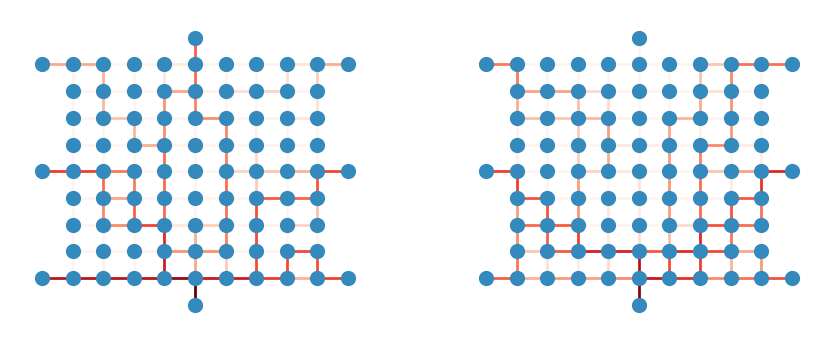

In [323]:
f0  = 0.06
fig = plt.figure(dpi=200)
fig.set_figheight(fig.get_figheight()*0.8)
fig.set_figwidth(fig.get_figwidth()*1.5)
leg_labels  = ['Min Gain', 'Max Gain']
for i, n in enumerate(GAIN_IDX):
    ax      = fig.add_subplot(1,2,i+1)
    df_net  = get_net_currents(currents[1600][n][f0].copy())
    rms     = np.sqrt((df_net**2).sum())
    G       = create_weighted_undirected_graph(rms)
    ax      = display_net_flow_graph(G, pos=pos, log_sacle=True, font_size=None, ax=ax, vmin=10, vmax=1500, node_size=20)
    # _       = ax.set_title(leg_labels[i])

fig.savefig(f"plots/pdf/network_currents_min_vs_max_gain.pdf", transparent=False)
fig.savefig(f"plots/svg/network_currents_min_vs_max_gain.svg", transparent=True)
fig.savefig(f"plots/png/network_currents_min_vs_max_gain.png", transparent=False)

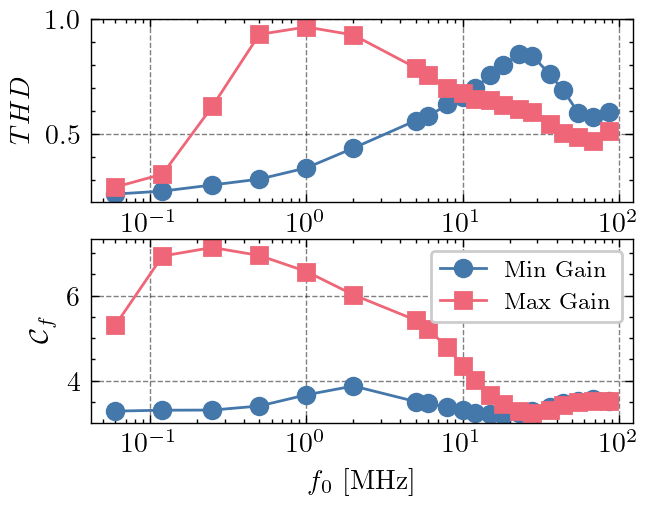

In [318]:
leg_labels  = ['Min Gain', 'Max Gain']
marker      = ['o','s','^']
R_VALUE     = 1600
fig         = plt.figure(dpi=200)
ax          = fig.add_subplot(2,1,1)
for i, n in enumerate(GAIN_IDX):
    THD_val = thds[R_VALUE][n]
    _       = ax.plot(FREQ_LIST_MHZ, THD_val, marker=marker[i])
_   = ax.set_xscale('log')
_   = ax.set_ylabel('$THD$')
ax  = fig.add_subplot(2,1,2)
for i, n in enumerate(GAIN_IDX):
    c_val   = centr[R_VALUE][n]
    _       = ax.plot(FREQ_LIST_MHZ, c_val, marker=marker[i], label=leg_labels[i])
_   = ax.set_xscale('log')
_   = ax.set_xlabel("$f_0$ [MHz]")
_   = ax.set_ylabel('$\mathcal{C}_f$')
_   = ax.legend(fontsize='small', loc='upper right')

fig.savefig(f"plots/pdf/nonlinearity_min_vs_max_gain.pdf", transparent=False)
fig.savefig(f"plots/svg/nonlinearity_min_vs_max_gain.svg", transparent=True)
fig.savefig(f"plots/png/nonlinearity_min_vs_max_gain.png", transparent=False)

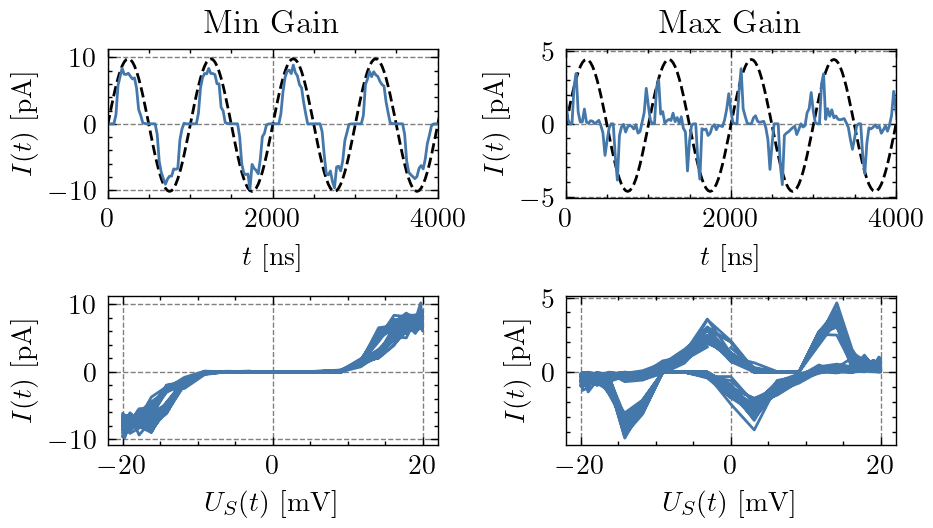

In [319]:
titles = ["Min Gain","Max Gain"]
f0s = 1.0
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
for i, n in enumerate(GAIN_IDX):
    ax      = fig.add_subplot(2,3,i+1)
    t_val   = time[f0s].copy()[:-(N_SKIP*SAMPLE_P_PERIOD)-1]
    x_val   = x[R_VALUE][n][f0s].copy()
    y_val   = y[R_VALUE][n][f0s].copy()*1e-6
    _       = ax.plot(t_val*1e9, y_val)
    _       = ax.plot(t_val*1e9, (y_val.max() - y_val.min())*(x_val-x_val.min()) / (x_val.max() - x_val.min()) - y_val.max(), color='black', ls='--', zorder=0.1)
    _       = ax.set_xlim(0,t_val[SAMPLE_P_PERIOD*4]*1e9)
    _       = ax.set_xlabel("$t$ [ns]")
    _       = ax.set_ylabel("$I(t)$ [pA]")
    _       = ax.set_title(titles[i])
for i, n in enumerate(GAIN_IDX):
    ax      = fig.add_subplot(2,3,i+4)
    t_val   = time[f0s].copy()[:-(N_SKIP*SAMPLE_P_PERIOD)-1]
    x_val   = x[R_VALUE][n][f0s].copy()*1000
    y_val   = y[R_VALUE][n][f0s].copy()*1e-6
    _       = ax.plot(x_val, y_val)
    _       = ax.set_xlabel("$U_S(t)$ [mV]")
    _       = ax.set_ylabel("$I(t)$ [pA]")

fig.savefig(f"plots/pdf/current_reponses_min_vs_max_gain_{f0s}.pdf", transparent=False)
fig.savefig(f"plots/svg/current_reponses_min_vs_max_gain_{f0s}.svg", transparent=True)
fig.savefig(f"plots/png/current_reponses_min_vs_max_gain_{f0s}.png", transparent=False)

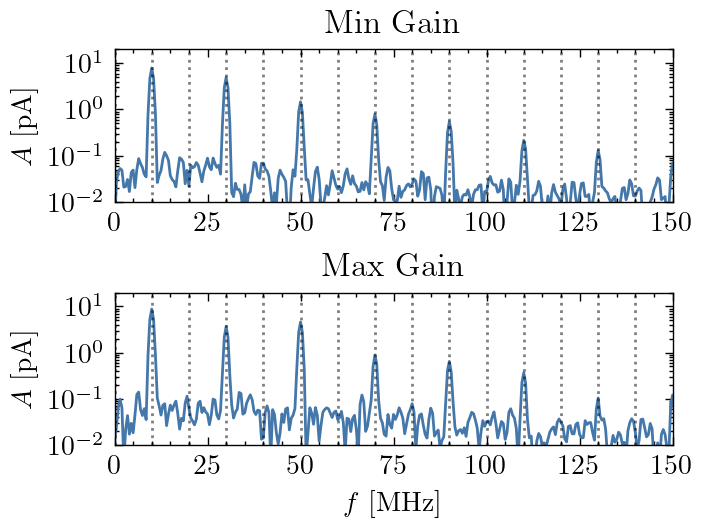

In [312]:
def get_frequency_spectrum(signal, dt):
    """
    Computes the calibrated one-sided amplitude spectrum.
    
    Parameters:
    - signal: 1D numpy array (time domain)
    - dt: Time step in seconds
    
    Returns:
    - freqs: Array of frequencies [Hz]
    - amplitudes: Array of physical amplitudes [A] (or whatever unit signal is in)
    """
    N_samples = len(signal)
    
    # 1. Apply Window (Consistent with your previous analysis)
    window = np.blackman(N_samples)
    y_windowed = signal * window
    
    # Window Coherent Gain Correction
    w_gain = np.sum(window) / N_samples
    
    # 2. Compute FFT
    fft_vals = np.fft.rfft(y_windowed)
    freqs = np.fft.rfftfreq(N_samples, dt)
    
    # 3. Normalize Magnitude
    # Scale for one-sided (*2), normalize by N, correct for window loss
    amplitudes = (np.abs(fft_vals) * 2 / N_samples) / w_gain
    
    return freqs, amplitudes

f0_val  = 10. #5.0 #0.5
fig     = plt.figure(dpi=200, layout='constrained')
for i, n in enumerate(GAIN_IDX):
    y_val   = y[R_VALUE][n][f0_val]
    xf, yf  = get_frequency_spectrum(y_val,dts[f0_val])
    ax      = fig.add_subplot(len(GAIN_IDX),1,i+1)
    _       = ax.semilogy(xf*1e-6, yf*1e-6)
    _       = ax.set_ylabel('$A$ [pA]')
    _       = ax.set_xlim(0,15*f0_val)
    _       = ax.set_ylim(0.01,20)
    _       = ax.set_title(titles[i])
    ax.grid(False)
    for n in range(15):
        plt.axvline(n*f0_val, color='black', ls=':', alpha=0.5)
_ = ax.set_xlabel("$f$ [MHz]")

fig.savefig(f"plots/pdf/frequency_reponses_min_vs_max_gain_{f0_val}.pdf", transparent=False)
fig.savefig(f"plots/svg/frequency_reponses_min_vs_max_gain_{f0_val}.svg", transparent=True)
fig.savefig(f"plots/png/frequency_reponses_min_vs_max_gain_{f0_val}.png", transparent=False)

### Current Percolation

In [45]:
NET_INDEX = [min_G_idx, max_G_idx]

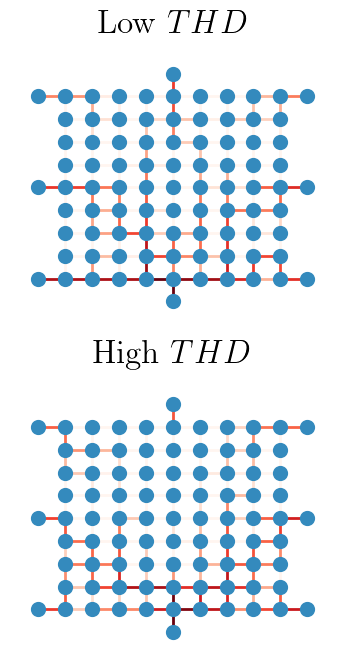

In [46]:
f0  = 5.0
fig = plt.figure(dpi=200)
fig.set_figheight(fig.get_figheight()*1.5)
fig.set_figwidth(fig.get_figwidth()*0.6)
for i, n in enumerate(NET_INDEX):
    ax      = fig.add_subplot(2,1,i+1)
    df_net  = get_net_currents(currents[R_VALUE][n][f0].copy())
    rms     = np.sqrt((df_net**2).sum())
    G       = create_weighted_undirected_graph(rms)
    ax      = display_net_flow_graph(G, pos=pos, log_sacle=True, font_size=None, ax=ax, vmin=10, vmax=1000, node_size=20)
    _       = ax.set_title(titles[i])
# fig.savefig(f"plots/pdf/network_currents_spec_Rs.pdf", transparent=False)
# fig.savefig(f"plots/svg/network_currents_spec_Rs.svg", transparent=True)
# fig.savefig(f"plots/png/network_currents_spec_Rs.png", transparent=False)

---